In [1]:
# EV Charging Desert Analysis - Jupyter Notebook Script
# Run this in Jupyter or convert to notebook using: jupyter nbconvert --to notebook ev_analysis.py

# EV Infrastructure Analysis: "Charging Deserts" Opportunity Study

## Executive Summary
This analysis identifies **High Priority Investment Zones** in Washington State where EV demand exceeds charging infrastructure supply.

## 1. Setup & Imports

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:,.2f}'.format)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Loading

In [3]:
ev = pd.read_csv('data/ev_population.csv')
stations = pd.read_csv('data/charging_stations.csv')

# Ensure ZIP codes are same type (string) for proper merging
# EV Postal Code is float64, Stations ZIP is int64 - need to normalize
ev['Postal Code'] = ev['Postal Code'].astype(str).str.replace('.0', '', regex=False)
stations['ZIP'] = stations['ZIP'].astype(str)

print(f"EV Population Data: {ev.shape[0]:,} rows, {ev.shape[1]} columns")
print(f"Charging Stations Data: {stations.shape[0]:,} rows, {stations.shape[1]} columns")

EV Population Data: 270,262 rows, 16 columns
Charging Stations Data: 3,064 rows, 75 columns


## 3. Data Inspection

In [4]:
print("=== EV Population Data Columns ===")
print(ev.columns.tolist())
print("\n=== EV Population Data Sample ===")
display(ev.head(3))

=== EV Population Data Columns ===
['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract']

=== EV Population Data Sample ===


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJYGDEE8L,Thurston,Tumwater,WA,98501,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291.00,35.00,124633715,POINT (-122.89165 47.03954),PUGET SOUND ENERGY INC,"53,067,011,720.00"
1,5YJXCAE2XJ,Snohomish,Bothell,WA,98021,2018,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238.00,1.00,474826075,POINT (-122.18384 47.8031),PUGET SOUND ENERGY INC,"53,061,051,914.00"
2,5YJ3E1EBXK,King,Kent,WA,98031,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.00,47.00,280307233,POINT (-122.17743 47.41185),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),"53,033,029,407.00"


In [5]:
print("=== Charging Stations Data Key Columns ===")
key_cols = ['Station Name', 'City', 'ZIP', 'Access Code', 'EV Level2 EVSE Num', 'EV DC Fast Count', 'Latitude', 'Longitude']
print(key_cols)
print("\n=== Charging Stations Data Sample ===")
display(stations[key_cols].head(3))

=== Charging Stations Data Key Columns ===
['Station Name', 'City', 'ZIP', 'Access Code', 'EV Level2 EVSE Num', 'EV DC Fast Count', 'Latitude', 'Longitude']

=== Charging Stations Data Sample ===


,Station Name,City,ZIP,Access Code,EV Level2 EVSE Num,EV DC Fast Count,Latitude,Longitude
0,Seattle-Tacoma International Airport - General...,Seattle,98188,public,68.00,NaN,47.44,-122.30
1,Avista Corp,Spokane,99252,public,2.00,NaN,47.67,-117.39
2,Steam Plant Parking,Spokane,99201,public,6.00,NaN,47.66,-117.42


## 4. Data Quality Check

In [6]:
print("=== EV Data Quality Check ===")
print(f"Missing values in Postal Code: {ev['Postal Code'].isna().sum():,}")
print(f"Unique Postal Codes: {ev['Postal Code'].nunique():,}")
print(f"\nElectric Vehicle Type distribution:")
print(ev['Electric Vehicle Type'].value_counts())

=== EV Data Quality Check ===
Missing values in Postal Code: 0
Unique Postal Codes: 1,084

Electric Vehicle Type distribution:
Electric Vehicle Type
Battery Electric Vehicle (BEV)            215859
Plug-in Hybrid Electric Vehicle (PHEV)     54403
Name: count, dtype: int64


In [7]:
print("=== Stations Data Quality Check ===")
print(f"Missing values in ZIP: {stations['ZIP'].isna().sum():,}")
print(f"Unique ZIPs: {stations['ZIP'].nunique():,}")
print(f"\nAccess Code distribution:")
print(stations['Access Code'].value_counts())

=== Stations Data Quality Check ===
Missing values in ZIP: 0
Unique ZIPs: 346

Access Code distribution:
Access Code
public     2864
private     200
Name: count, dtype: int64


## 5. Data Cleaning

### Business Logic:
- **BEV Only**: Battery Electric Vehicles rely 100% on public charging (no gas backup)
- **Public Stations Only**: We're analyzing public infrastructure gaps

In [8]:
# Filter for Washington State only
ev_wa = ev[ev['State'] == 'WA'].copy()
print(f"WA vehicles: {ev_wa.shape[0]:,} (filtered from {ev.shape[0]:,} total)")

# Filter for BEV only (pure EVs)
ev_bev = ev_wa[ev_wa['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)'].copy()
print(f"WA BEV vehicles: {ev_bev.shape[0]:,}")

# Filter for public stations only
stations_public = stations[stations['Access Code'] == 'public'].copy()
print(f"Public stations: {stations_public.shape[0]:,} (filtered from {stations.shape[0]:,} total)")

WA vehicles: 269,613 (filtered from 270,262 total)
WA BEV vehicles: 215,384
Public stations: 2,864 (filtered from 3,064 total)


## 6. Feature Engineering - Create Total_Ports Column

In [9]:
stations_public['EV Level2 EVSE Num'] = stations_public['EV Level2 EVSE Num'].fillna(0)
stations_public['EV DC Fast Count'] = stations_public['EV DC Fast Count'].fillna(0)
stations_public['Total_Ports'] = (
    stations_public['EV Level2 EVSE Num'] +
    stations_public['EV DC Fast Count']
)

print(f"Total public ports across WA: {stations_public['Total_Ports'].sum():,}")
print(f"Stations with 0 ports: {(stations_public['Total_Ports'] == 0).sum():,}")

Total public ports across WA: 7,943.0
Stations with 0 ports: 2


## 7. Aggregation by ZIP Code

In [10]:
# Aggregate EVs by ZIP code
ev_by_zip = ev_bev.groupby('Postal Code').agg(
    Total_EVs=('VIN (1-10)', 'count'),
    County=('County', 'first'),
    City=('City', lambda x: x.mode()[0] if len(x) > 0 else '')
).reset_index()

print(f"ZIP codes with EVs: {ev_by_zip.shape[0]:,}")
display(ev_by_zip.head())

ZIP codes with EVs: 566


,Postal Code,Total_EVs,County,City
0,98001,1014,King,Auburn
1,98002,368,King,Auburn
2,98003,760,King,Federal Way
3,98004,3415,King,Bellevue
4,98005,1719,King,Bellevue


In [11]:
# Aggregate ports by ZIP code
ports_by_zip = stations_public.groupby('ZIP').agg(
    Total_Ports=('Total_Ports', 'sum'),
    Latitude=('Latitude', 'mean'),
    Longitude=('Longitude', 'mean')
).reset_index()

print(f"ZIP codes with stations: {ports_by_zip.shape[0]:,}")
display(ports_by_zip.head())

ZIP codes with stations: 329


,ZIP,Total_Ports,Latitude,Longitude
0,10009,4.00,45.63,-122.67
1,98001,37.00,47.29,-122.24
2,98002,29.00,47.31,-122.22
3,98003,58.00,47.30,-122.32
4,98004,451.00,47.61,-122.20


## 8. Master DataFrame & Opportunity Metric

In [12]:
# Merge datasets on ZIP code
df = ev_by_zip.merge(
    ports_by_zip,
    left_on='Postal Code',
    right_on='ZIP',
    how='left'
)

# Fill missing ports with 0 (these are true "deserts")
df['Total_Ports'] = df['Total_Ports'].fillna(0).astype(int)

# Get coordinates from EV data for missing ZIPs
# Vehicle Location format: POINT (-122.89165 47.03954)
def extract_coords(location):
    try:
        parts = str(location).split()
        if len(parts) >= 3:
            lon = float(parts[1].replace('(', ''))
            lat = float(parts[2].replace(')', ''))
            return lat, lon
    except:
        pass
    return 47.5, -120.5  # Default WA center

zip_coords = ev_bev.groupby('Postal Code')['Vehicle Location'].first().apply(extract_coords)
df['Latitude'] = df['Latitude'].fillna(zip_coords.apply(lambda x: x[0]))
df['Longitude'] = df['Longitude'].fillna(zip_coords.apply(lambda x: x[1]))

# Calculate Opportunity Metric: EV_to_Port_Ratio
df['EV_to_Port_Ratio'] = np.where(
    df['Total_Ports'] > 0,
    df['Total_EVs'] / df['Total_Ports'],
    np.inf  # Infinite ratio when no ports exist
)

# Add Priority Category
def categorize_priority(ratio):
    if ratio == np.inf:
        return 'CRITICAL - No Ports'
    elif ratio > 100:
        return 'High Opportunity'
    elif ratio > 50:
        return 'Medium Opportunity'
    else:
        return 'Well Served'

df['Priority_Level'] = df['EV_to_Port_Ratio'].apply(categorize_priority)

print(f"Master dataframe: {df.shape[0]:,} ZIP codes")
display(df.head(10))

Master dataframe: 566 ZIP codes


,Postal Code,Total_EVs,County,City,ZIP,Total_Ports,Latitude,Longitude,EV_to_Port_Ratio,Priority_Level
0,98001,1014,King,Auburn,98001,37,47.29,-122.24,27.41,Well Served
1,98002,368,King,Auburn,98002,29,47.31,-122.22,12.69,Well Served
2,98003,760,King,Federal Way,98003,58,47.30,-122.32,13.10,Well Served
3,98004,3415,King,Bellevue,98004,451,47.61,-122.20,7.57,Well Served
4,98005,1719,King,Bellevue,98005,147,47.62,-122.17,11.69,Well Served
5,98006,3633,King,Bellevue,98006,14,47.57,-122.16,259.50,High Opportunity
6,98007,1269,King,Bellevue,98007,31,47.59,-122.14,40.94,Well Served
7,98008,1913,King,Bellevue,98008,11,47.61,-122.13,173.91,High Opportunity
8,98010,503,King,Black Diamond,NaN,0,NaN,NaN,inf,CRITICAL - No Ports
9,98011,1538,King,Bothell,98011,56,47.76,-122.19,27.46,Well Served


## 9. Strategic Insights

In [13]:
print("=== KEY METRICS ===")
total_evs = df['Total_EVs'].sum()
total_ports = df['Total_Ports'].sum()
print(f"\nTotal BEVs in Washington: {total_evs:,}")
print(f"Total Public Charging Ports: {total_ports:,}")
if total_ports > 0:
    print(f"Statewide Average EV/Port Ratio: {total_evs / total_ports:.1f}")

print(f"\nZIP codes with NO public charging: {(df['Total_Ports'] == 0).sum():,}")
print(f"EVs in charging deserts (0 ports): {df[df['Total_Ports'] == 0]['Total_EVs'].sum():,}")

=== KEY METRICS ===

Total BEVs in Washington: 215,384
Total Public Charging Ports: 7,876
Statewide Average EV/Port Ratio: 27.3

ZIP codes with NO public charging: 250
EVs in charging deserts (0 ports): 13,444


In [14]:
print("=== PRIORITY DISTRIBUTION ===")
priority_summary = df.groupby('Priority_Level').agg(
    ZIP_Count=('Postal Code', 'count'),
    Total_EVs=('Total_EVs', 'sum'),
    Total_Ports=('Total_Ports', 'sum')
).sort_values('ZIP_Count', ascending=False)
display(priority_summary)

=== PRIORITY DISTRIBUTION ===


,ZIP_Count,Total_EVs,Total_Ports
Priority_Level,,,
CRITICAL - No Ports,250,13444,0
Well Served,219,90094,6874
High Opportunity,49,65372,338
Medium Opportunity,48,46474,664


## 10. Top 10 Target List
### The "Immediate Construction Sites" - High EV count, minimal infrastructure

In [15]:
priority_targets = df[
    (df['Total_Ports'] < 2) &
    (df['Total_EVs'] > 50)
].sort_values('Total_EVs', ascending=False).head(10).copy()

# Format for display
priority_targets['Display_Ratio'] = priority_targets['EV_to_Port_Ratio'].apply(
    lambda x: '∞' if x == np.inf else f'{x:.0f}'
)

print("=== TOP 10 HIGH PRIORITY INVESTMENT ZONES ===")
print("Criteria: >50 EVs, <2 public charging ports")
display(priority_targets[['Postal Code', 'County', 'Total_EVs', 'Total_Ports', 'Display_Ratio', 'Priority_Level']])

=== TOP 10 HIGH PRIORITY INVESTMENT ZONES ===
Criteria: >50 EVs, <2 public charging ports


,Postal Code,County,Total_EVs,Total_Ports,Display_Ratio,Priority_Level
30,98038,King,1944,0,∞,CRITICAL - No Ports
90,98177,King,1270,1,1270,High Opportunity
77,98126,King,911,1,911,High Opportunity
91,98178,King,811,1,811,High Opportunity
12,98019,King,770,0,∞,CRITICAL - No Ports
82,98146,King,733,1,733,High Opportunity
261,98506,Thurston,580,0,∞,CRITICAL - No Ports
8,98010,King,503,0,∞,CRITICAL - No Ports
122,98248,Whatcom,476,0,∞,CRITICAL - No Ports
184,98338,Pierce,437,1,437,High Opportunity


## 11. Strategic Map - Bubble Visualization

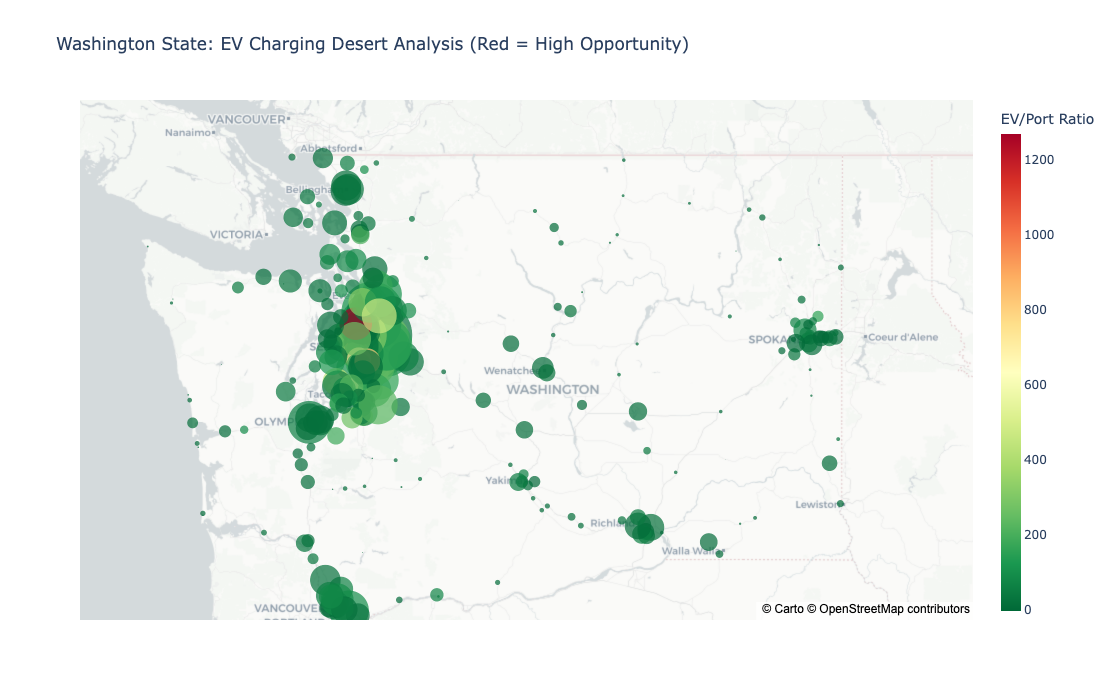

In [17]:
fig = px.scatter_mapbox(
    df,
    lat='Latitude',
    lon='Longitude',
    size='Total_EVs',
    color='EV_to_Port_Ratio',
    color_continuous_scale='RdYlGn_r',
    size_max=50,
    opacity=0.7,
    mapbox_style='carto-positron',
    center={'lat': 47.5, 'lon': -120.5},
    zoom=6,
    title='Washington State: EV Charging Desert Analysis (Red = High Opportunity)',
    hover_data={
        'Postal Code': True,
        'County': True,
        'Total_EVs': True,
        'Total_Ports': True,
        'EV_to_Port_Ratio': ':.1f'
    }
)

fig.update_layout(
    coloraxis_colorbar=dict(title="EV/Port Ratio", thickness=20),
    height=700
)

fig.show()

## 12. Export Results

In [18]:
# Save map
fig.write_html('output/charging_desert_map.html')
print("Map saved to: output/charging_desert_map.html")

# Export Top 50 targets
top_targets = df[df['Total_EVs'] > 20].sort_values('EV_to_Port_Ratio', ascending=False).head(50)
top_targets[['Postal Code', 'County', 'City', 'Total_EVs', 'Total_Ports', 'EV_to_Port_Ratio', 'Priority_Level']].to_csv(
    'output/top_50_investment_zones.csv', index=False
)
print("Top 50 targets exported to: output/top_50_investment_zones.csv")

Map saved to: output/charging_desert_map.html
Top 50 targets exported to: output/top_50_investment_zones.csv
